In [23]:
import keras,os,matplotlib.pyplot as plt,glob,pandas as pd,seaborn as sn
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import scipy

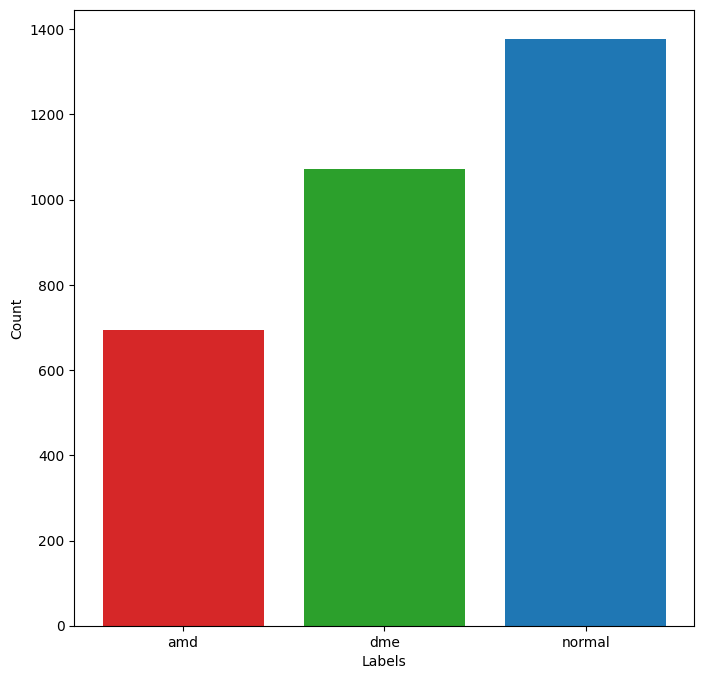

In [24]:
amd_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/amd"))
dme_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/dme"))
normal_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/normal"))
data= {'amd': amd_images, 'dme': dme_images, 'normal': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

batchSize=16

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

In [25]:
trdata = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)
traindata = trdata.flow_from_directory(
    directory="/home/kmh/Desktop/newnewdataset/training",
    target_size=(224,224),
    batch_size= batchSize,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

tsdata = ImageDataGenerator(
    rescale= 1./255,
)
testdata = tsdata.flow_from_directory(
    directory="/home/kmh/Desktop/newnewdataset/testing", 
    target_size=(224,224),
    batch_size= batchSize,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

Found 3141 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [26]:
num_classes = len(traindata.class_indices)  
train_labels = traindata.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = testdata.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(traindata.filenames)  
nb_valid_samples = len(testdata.filenames)

In [27]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [28]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/home/kmh/Desktop/SEM7/DL/proj-test/env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
checkpoint = ModelCheckpoint(
   'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

# csvlogger = CSVLogger(
#     filename= "baseline_training_csv.log",
#     separator = ",",
#     append = False
# )

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, reduceLR]

In [30]:
history = model.fit(
    traindata, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batchSize,
    validation_data = testdata, 
    validation_steps = nb_valid_samples//batchSize,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.72864, saving model to baseline_model.h5
196/196 - 1182s - loss: 0.8138 - accuracy: 0.5942 - val_loss: 0.7286 - val_accuracy: 0.6500 - lr: 1.0000e-04 - 1182s/epoch - 6s/step
Epoch 2/30

Epoch 2: val_loss improved from 0.72864 to 0.70425, saving model to baseline_model.h5
196/196 - 1154s - loss: 0.6267 - accuracy: 0.6896 - val_loss: 0.7043 - val_accuracy: 0.7000 - lr: 1.0000e-04 - 1154s/epoch - 6s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.70425 to 0.69505, saving model to baseline_model.h5
196/196 - 1170s - loss: 0.5382 - accuracy: 0.7222 - val_loss: 0.6950 - val_accuracy: 0.5875 - lr: 1.0000e-04 - 1170s/epoch - 6s/step
Epoch 4/30

Epoch 4: val_loss improved from 0.69505 to 0.66478, saving model to baseline_model.h5
196/196 - 1179s - loss: 0.5427 - accuracy: 0.7354 - val_loss: 0.6648 - val_accuracy: 0.6750 - lr: 1.0000e-04 - 1179s/epoch - 6s/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.66478
196/196 - 1158s - los

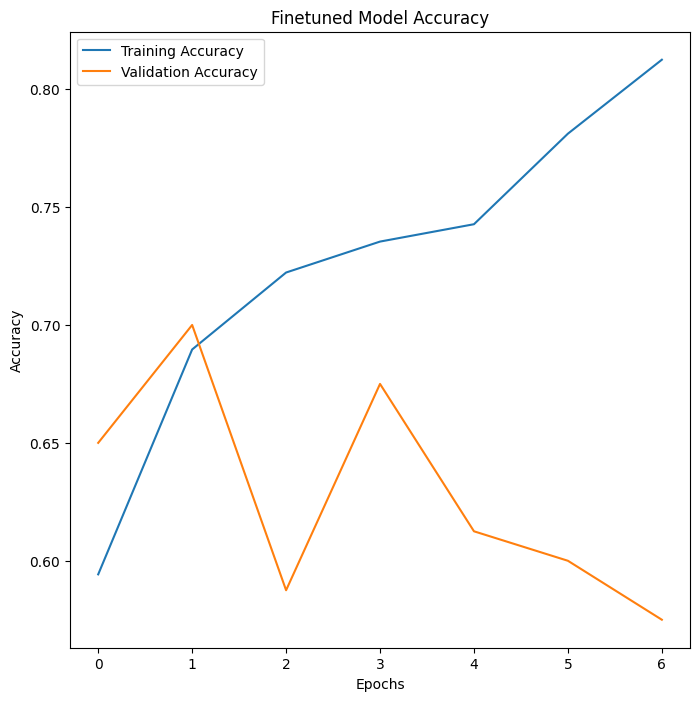

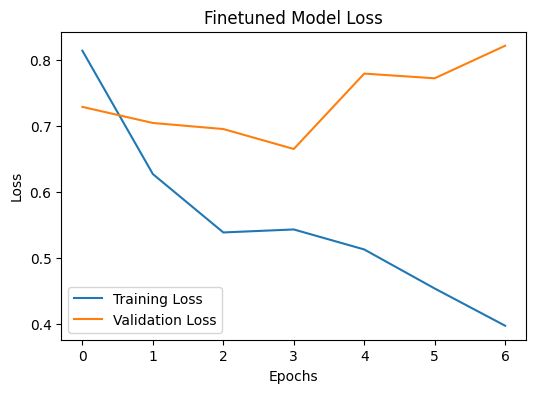

In [31]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [32]:
(eval_loss, eval_accuracy) = model.evaluate(testdata, batch_size= batchSize, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

6/6 [==============================] - 10s 2s/step - loss: 0.8992 - accuracy: 0.5667
Test Loss:  0.8992311358451843
Test Accuracy:  0.5666666626930237


6/6 [==============================] - 11s 2s/step


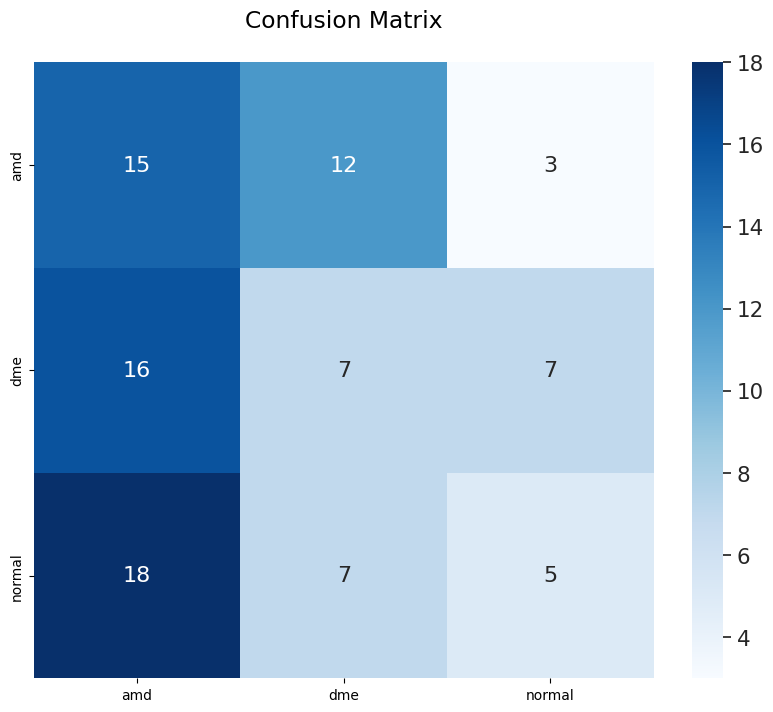

Classification Report

              precision    recall  f1-score   support

         amd       0.31      0.50      0.38        30
         dme       0.27      0.23      0.25        30
      normal       0.33      0.17      0.22        30

    accuracy                           0.30        90
   macro avg       0.30      0.30      0.28        90
weighted avg       0.30      0.30      0.28        90



In [33]:
Y_pred = model.predict(testdata, 90 // batchSize+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)
df_cm = pd.DataFrame(cm, list(testdata.class_indices.keys()), list(testdata.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(testdata.class_indices.keys())
print(classification_report(testdata.classes, y_pred, target_names=target_names))
